In [1]:
import json
import lzma
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from IPython.core.display import display, HTML
import re
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

import matplotlib.ticker as ticker

import unicodedata
import re
import numpy as np
import os
import io
import time

Using TensorFlow backend.


In [2]:
def text_cleaner(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [3]:
# experimenting
text = 'my text \n yes.!$'
text_cleaner(text)

'<start> my text yes . ! <end>'

In [4]:
def get_cases(state, subset=True, num_cases=100):
    cases = []
    with lzma.open(state + '/data/data.jsonl.xz', 'r') as jsonl_file:
        for i, case in enumerate(jsonl_file):
            c = json.loads(str(case, 'utf-8'))

            date = c['decision_date']
            
            headnotes = c['casebody']['data']['head_matter']
            if headnotes == []:
                continue
            headnotes = text_cleaner(headnotes)
            num_head = len(headnotes)
            
            name = text_cleaner(c['name'])
            docket_number = text_cleaner(c['docket_number'])

            opinions = c['casebody']['data']['opinions']
            if opinions == []:
                continue

            opinions = text_cleaner(opinions[0]['text'])
            body = name + docket_number + opinions
            num_body = len(body)
                
            cases.append({'date':date, 'num_head':num_head, 'head':headnotes, 'num_body':num_body, 'body':body})
            if subset == True:
                if i > num_cases:
                    break
        return pd.DataFrame(cases)

In [5]:
df = get_cases('North Carolina', subset=False, num_cases=10)
df.shape

(97586, 5)

In [9]:
df.head()

,date,num_head,head,num_body,body
0,1998-07-08,37,<start> state v . booker no . p <end>,146,<start> state v . booker <end><start> no . p <...
1,1998-07-29,35,<start> state v . ward no . p <end>,122,<start> state v . ward <end><start> no . p <en...
2,1998-05-08,66,<start> street v . integrated system solutions...,228,<start> street v . integrated system solutions...
3,1998-07-08,37,<start> state v . brewer no . p <end>,191,<start> state v . brewer <end><start> no . p <...
4,1998-05-08,38,<start> state v . springs no . p <end>,184,<start> state v . springs <end><start> no . p ...


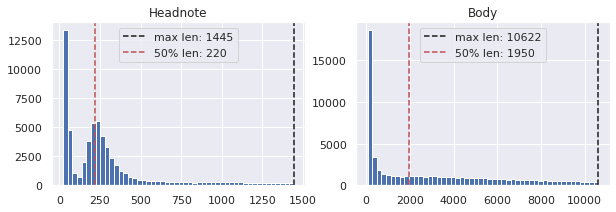

In [12]:
q = 50
q_head = int(np.percentile(df.num_head,q))
q_body = int(np.percentile(df.num_body,q))

f, ax = plt.subplots(1,2,figsize=[10,3])
ax[0].hist(df.num_head, bins=50)
ax[0].axvline(np.max(df.num_head), label='max len: ' + str(np.max(df.num_head)), color='k', ls='--')
ax[0].axvline(q_head, label=str(q) + '% len: ' + str(q_head), color='r', ls='--')
ax[0].set_title('Headnote')
ax[0].legend()
ax[1].hist(df.num_body, bins=50)
ax[1].axvline(np.max(df.num_body), label='max len: ' + str(np.max(df.num_body)), color='k', ls='--')
ax[1].axvline(q_body, label=str(q) + '% len: ' + str(q_body), color='r', ls='--')
ax[1].legend()
ax[1].set_title('Body')
plt.show()

In [13]:
# limiting the dataset
max_head = q_head
max_body = q_body

df = df[(df['num_head'] <= q_head) & (df['num_head'] > 4) & 
        (df['num_body'] <= q_body) & (df['num_body'] > 4)]
print(df.shape)
display(df[['num_head']].describe().T)
display(df[['num_body']].describe().T)

(23638, 5)


,count,mean,std,min,25%,50%,75%,max
num_head,23638.0,73.030163,53.007456,23.0,39.0,47.0,75.0,220.0


,count,mean,std,min,25%,50%,75%,max
num_body,23638.0,325.86234,371.872063,64.0,148.0,175.0,275.0,1950.0


65
574


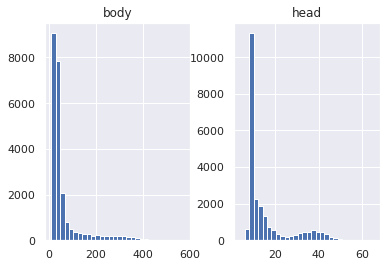

In [14]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['body']:
      text_word_count.append(len(i.split()))

for i in df['head']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'body':text_word_count, 'head':summary_word_count})
max_length_targ = length_df['head'].max()
max_length_inp = length_df['body'].max()
print(max_length_targ)
print(max_length_inp)
length_df.hist(bins = 30)
plt.show()

In [15]:
def tokenize(data):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(data)

    tensor = tokenizer.texts_to_sequences(data)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

input_tensor, inp_lang = tokenize(df['body'])
target_tensor, targ_lang = tokenize(df['head'])

# input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(65, 574)

In [37]:
# Creating training and validation sets using an 80-20 split
x_tr, x_val, y_tr, y_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(x_tr), len(x_val), len(y_tr), len(y_val))

18910 4728 18910 4728


In [34]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 500
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

def pipeline(x, y):
    
    return tf.data.Dataset.from_tensor_slices((x,y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# x_tr = pipeline(input_tensor_train)
# x_val = pipeline(input_tensor_val)
# y_tr = pipeline(target_tensor_train)
# y_val = pipeline(target_tensor_val)

dataset = pipeline(input_tensor_train, target_tensor_train)
val = pipeline(input_tensor_val, target_tensor_val)

# Model

In [43]:

# article input model
inputs1 = Input(shape=(max_length_inp,))
article1 = Embedding(vocab_inp_size, 128)(inputs1)
article2 = LSTM(128)(article1)
article3 = tf.keras.layers.RepeatVector(max_length_targ)(article2)
# summary input model
inputs2 = Input(shape=(max_length_targ,))
summ1 = Embedding(vocab_inp_size, 128)(inputs2)
# decoder model
decoder1 = tf.keras.layers.concatenate([article3, summ1])
decoder2 = LSTM(128)(decoder1)
outputs = Dense(vocab_inp_size, activation='softmax')(decoder2)
# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 574)]        0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 574, 128)     3105792     input_15[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 128)          131584      embedding_14[0][0]               
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 65)]         0                                            
____________________________________________________________________________________________

In [44]:
history=model.fit([x_tr, y_tr], y_tr,
                  epochs=10,
                  batch_size=64, 
                  validation_data=[x_val,y_val, y_val])

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[  11,   20,    5, ...,    0,    0,    0],
       [  11,  272,    8, ...,    0,    0,    0],
       [  11,   20,    8, ...,    0,    0,    0],
       ...,
       [  11,   20,    8, ...,    0, ...

In [39]:
# history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
#                   epochs=50,
#                   batch_size=512, 
#                   validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [ ]:
history=model.fit(x = [x_tr, train_X_y_tr], y = train_y,
                  epochs=50, batch_size=512, 
                  validation_data = ([val_X_x_val, val_X_y_val], val_y))

In [36]:
# history = model.fit(dataset, epochs=10, validation_data=target_tensor_val)